# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

plt.style.use("ggplot")


# Load and Clean the Data

In [ ]:
df = pd.read_excel("/content/online_retail_II.xlsx")
df_sample = df.head(10)
df_sample

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.6500,13085.0000,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.9500,13085.0000,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.5500,13085.0000,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.7500,13085.0000,United Kingdom


In [ ]:
# Drop rows with missing Customer ID
df.dropna(subset=['Customer ID'], inplace=True)

# Remove cancelled invoices
df = df[~df['Invoice'].astype(str).str.contains('C')]

# Remove negative quantity and price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Create TotalAmount
df['TotalAmount'] = df['Quantity'] * df['Price']

# Convert date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Initial Data Overview
print(df.head())


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  TotalAmount  
0 2009-12-01 07:45:00 6.9500   13085.0000  United Kingdom      83.4000  
1 2009-12-01 07:45:00 6.7500   13085.0000  United Kingdom      81.0000  
2 2009-12-01 07:45:00 6.7500   13085.0000  United Kingdom      81.0000  
3 2009-12-01 07:45:00 2.1000   13085.0000  United Kingdom     100.8000  
4 2009-12-01 07:45:00 1.2500   13085.0000  United Kingdom      30.0000  


# Exploratory Data Analysis (EDA)

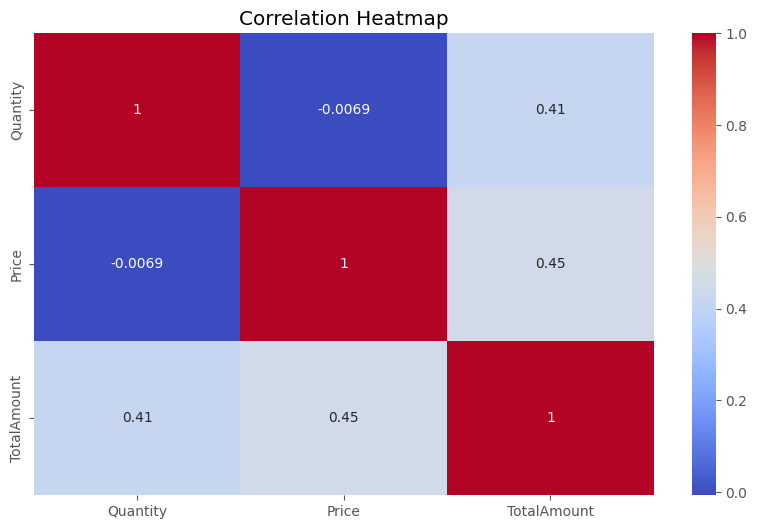

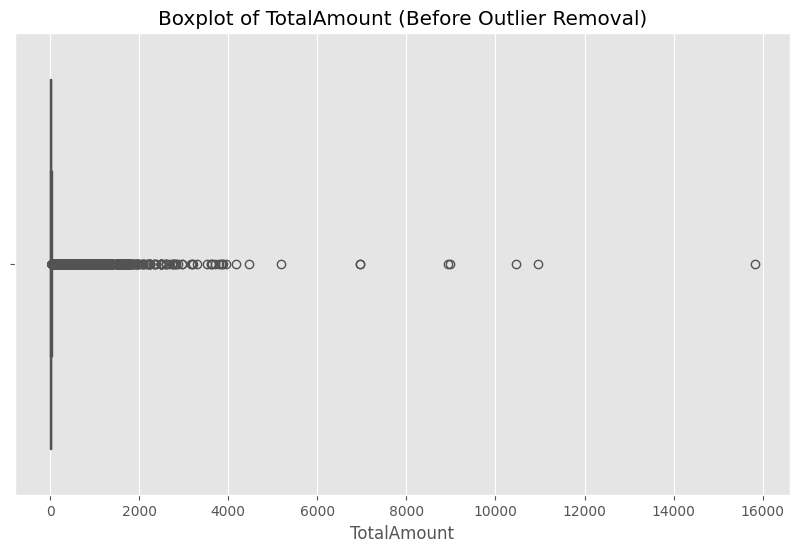

In [ ]:
# Heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Quantity', 'Price', 'TotalAmount']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Boxplot of TotalAmount (before cleaning outliers)
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['TotalAmount'])
plt.title("Boxplot of TotalAmount (Before Outlier Removal)")
plt.show()



# Feature Engineering (RFM + CLV)

In [ ]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalAmount': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalAmount': 'Monetary'}).reset_index()

# Derived features
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']
rfm['CLV'] = rfm['Monetary']

print(rfm.describe())


       Customer ID   Recency  Frequency    Monetary  AvgOrderValue         CLV
count    3969.0000 3969.0000  3969.0000   3969.0000      3969.0000   3969.0000
mean    15561.4061   91.0950     4.4374   1868.1673       353.1165   1868.1673
std      1582.0998   97.0718     7.5319   7380.8300       450.1253   7380.8300
min     12346.0000    1.0000     1.0000      2.9500         2.9500      2.9500
25%     14201.0000   18.0000     1.0000    304.2000       177.4250    304.2000
50%     15577.0000   52.0000     2.0000    669.9100       278.1267    669.9100
75%     16941.0000  136.0000     5.0000   1655.6400       401.7980   1655.6400
max     18287.0000  374.0000   155.0000 349164.3500     11880.8400 349164.3500


# Outlier Removal & Log Transform

In [ ]:
# Outlier removal using IQR method
q1, q3 = rfm['CLV'].quantile([0.25, 0.75])
iqr = q3 - q1
rfm = rfm[(rfm['CLV'] >= q1 - 1.5 * iqr) & (rfm['CLV'] <= q3 + 1.5 * iqr)]

# Log transform
rfm['CLV'] = np.log1p(rfm['CLV'])


# Train & Evaluat Multiple Models

In [ ]:
X = rfm.drop(columns=['Customer ID', 'CLV'])
y = rfm['CLV']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
models = {
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

results = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred

    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False).reset_index()
results_df.rename(columns={'index': 'Model'}, inplace=True)
print(results_df)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 2865, number of used features: 4
[LightGBM] [Info] Start training from score 6.338393
          Model    MAE    MSE   RMSE     R2
0  RandomForest 0.0013 0.0000 0.0045 1.0000
1  DecisionTree 0.0018 0.0000 0.0059 1.0000
2       XGBoost 0.0070 0.0006 0.0242 0.9995
3      LightGBM 0.0092 0.0021 0.0458 0.9980


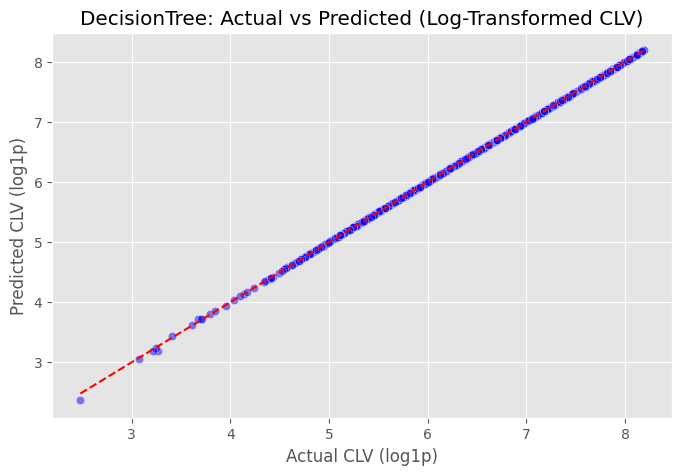

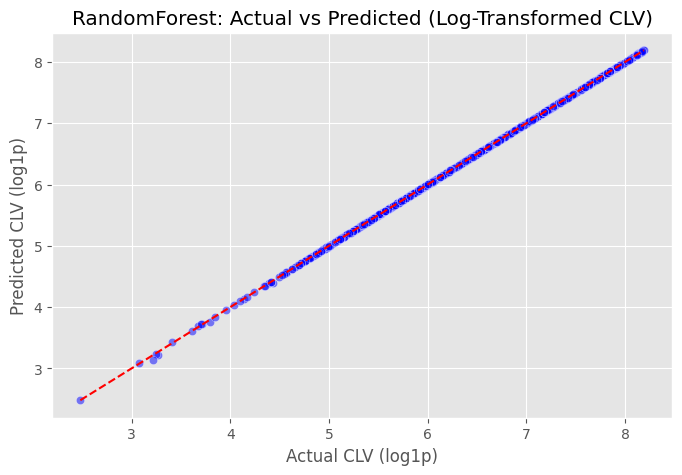

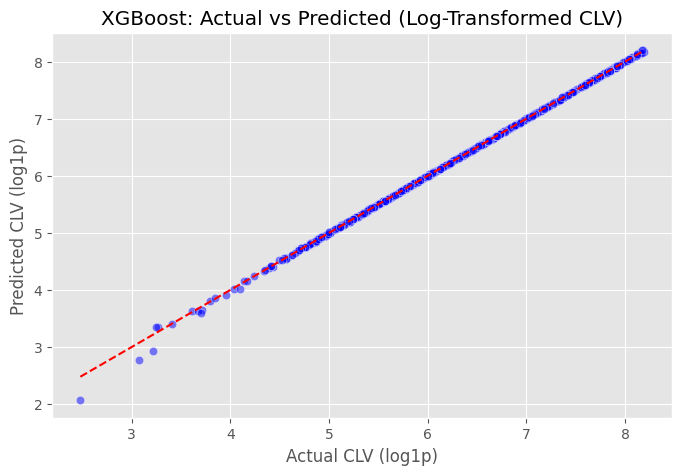

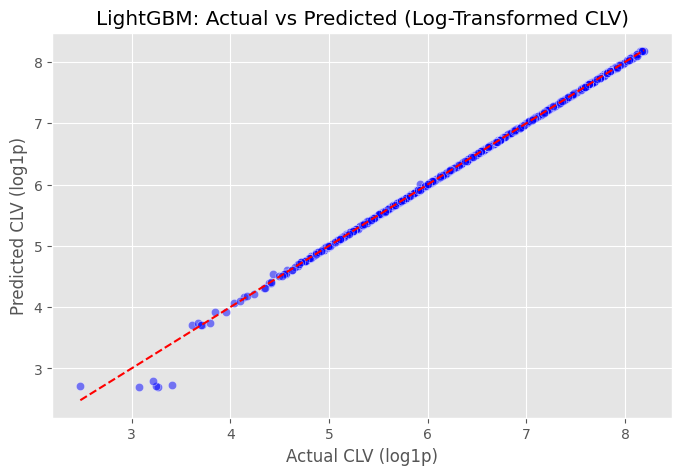

In [ ]:
# Plotting Actual vs Predicted
for name in predictions:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test, y=predictions[name], alpha=0.5, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.title(f"{name}: Actual vs Predicted (Log-Transformed CLV)")
    plt.xlabel("Actual CLV (log1p)")
    plt.ylabel("Predicted CLV (log1p)")
    plt.grid(True)
    plt.show()


In [ ]:
actual_original = np.expm1(y_test)

for name in predictions:
    pred_original = np.expm1(predictions[name])

    mae = mean_absolute_error(actual_original, pred_original)
    mse = mean_squared_error(actual_original, pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_original, pred_original)

    print(f"\n📊 {name} Model Performance (after inverse transform):")
    print(f"Test MAE  : {mae:.2f}")
    print(f"Test MSE  : {mse:.2f}")
    print(f"Test RMSE : {rmse:.2f}")
    print(f"Test R2   : {r2:.4f}")



📊 DecisionTree Model Performance (after inverse transform):
Test MAE  : 1.19
Test MSE  : 6.01
Test RMSE : 2.45
Test R2   : 1.0000

📊 RandomForest Model Performance (after inverse transform):
Test MAE  : 0.73
Test MSE  : 2.32
Test RMSE : 1.52
Test R2   : 1.0000

📊 XGBoost Model Performance (after inverse transform):
Test MAE  : 4.75
Test MSE  : 110.27
Test RMSE : 10.50
Test R2   : 0.9998

📊 LightGBM Model Performance (after inverse transform):
Test MAE  : 4.26
Test MSE  : 76.91
Test RMSE : 8.77
Test R2   : 0.9999


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


y_test_actual = np.expm1(y_test)

dt_pred = np.expm1(predictions['DecisionTree'])
rf_pred = np.expm1(predictions['RandomForest'])
xgb_pred = np.expm1(predictions['XGBoost'])
lgbm_pred = np.expm1(predictions['LightGBM'])


results_df = pd.DataFrame({
    'Actual': y_test_actual.values,
    'DecisionTree': dt_pred,
    'RandomForest': rf_pred,
    'XGBoost': xgb_pred,
    'LightGBM': lgbm_pred
})

# Calculate Difference Columns
results_df['DecisionTree_Diff'] = abs(results_df['Actual'] - results_df['DecisionTree'])
results_df['RandomForest_Diff'] = abs(results_df['Actual'] - results_df['RandomForest'])
results_df['XGBoost_Diff'] = abs(results_df['Actual'] - results_df['XGBoost'])
results_df['LightGBM_Diff'] = abs(results_df['Actual'] - results_df['LightGBM'])


# Show first few rows
print(results_df[['Actual', 'DecisionTree', 'DecisionTree_Diff',
                  'RandomForest', 'RandomForest_Diff',
                  'XGBoost', 'XGBoost_Diff',
                  'LightGBM', 'LightGBM_Diff']].head(10))



     Actual  DecisionTree  DecisionTree_Diff  RandomForest  RandomForest_Diff  \
0  340.8600      340.8400             0.0200      340.7221             0.1379   
1  823.0000      823.1400             0.1400      823.4125             0.4125   
2   39.9500       40.0000             0.0500       40.3254             0.3754   
3 2542.7900     2543.1900             0.4000     2543.6548             0.8648   
4  426.2400      426.5300             0.2900      426.6798             0.4398   
5  337.0400      336.6000             0.4400      336.5907             0.4493   
6  214.8000      214.1300             0.6700      214.7151             0.0849   
7 1375.6500     1376.0900             0.4400     1375.6950             0.0450   
8  221.6900      221.5300             0.1600      221.6472             0.0428   
9  677.9700      678.7700             0.8000      678.5192             0.5492   

    XGBoost  XGBoost_Diff  LightGBM  LightGBM_Diff  
0  342.0124        1.1524  342.6069         1.7469  
1 

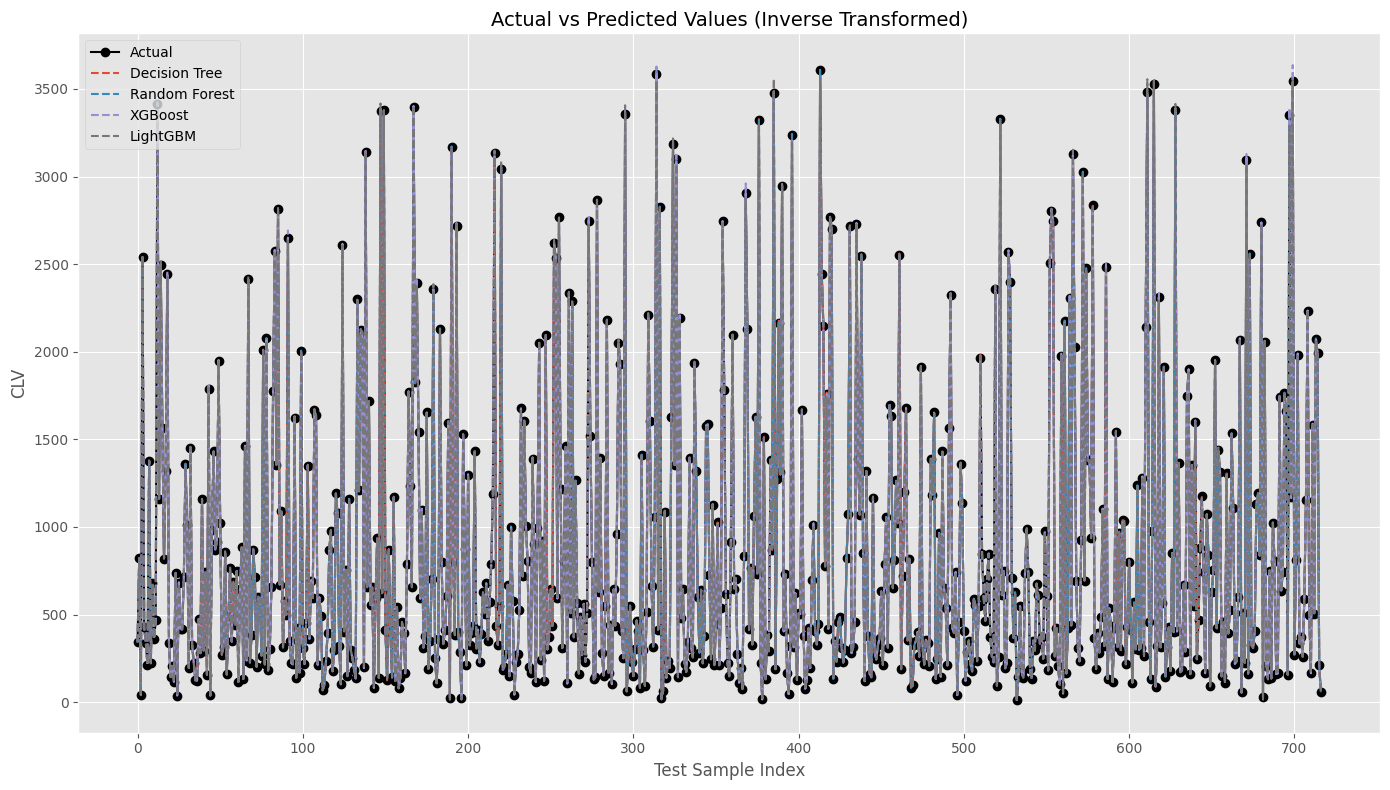

In [ ]:
# Plot Actual vs Predicted for All Models
plt.figure(figsize=(14, 8))
plt.plot(results_df['Actual'].values, label='Actual', marker='o', color='black')
plt.plot(results_df['DecisionTree'].values, label='Decision Tree', linestyle='--')
plt.plot(results_df['RandomForest'].values, label='Random Forest', linestyle='--')
plt.plot(results_df['XGBoost'].values, label='XGBoost', linestyle='--')
plt.plot(results_df['LightGBM'].values, label='LightGBM', linestyle='--')
plt.title('Actual vs Predicted Values (Inverse Transformed)', fontsize=14)
plt.xlabel('Test Sample Index')
plt.ylabel('CLV')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mean_diffs = {
    'DecisionTree': results_df['DecisionTree_Diff'].mean(),
    'RandomForest': results_df['RandomForest_Diff'].mean(),
    'XGBoost': results_df['XGBoost_Diff'].mean(),
    'LightGBM': results_df['LightGBM_Diff'].mean()
}

summary_df = pd.DataFrame(mean_diffs, index=['Mean Absolute Difference']).T
print("\n📊 Mean Absolute Differences by Model:")
display(summary_df.sort_values('Mean Absolute Difference'))


📊 Mean Absolute Differences by Model:


,Mean Absolute Difference
RandomForest,0.7343
DecisionTree,1.1917
LightGBM,4.2635
XGBoost,4.7537


In [ ]:
import pickle

# Save the Random Forest model
with open('rf_clv_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the Scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [ ]:
# Print the column names of the features (from the rfm DataFrame before scaling)
print(rfm.columns)

Index(['Customer ID', 'Recency', 'Frequency', 'Monetary', 'AvgOrderValue',
       'CLV'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary', 'AvgOrderValue']])


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 0.0070234386063533156
RMSE: 0.029898112547625
R2 Score: 0.9991614831337415


In [ ]:
from xgboost import XGBRegressor

model.save_model("clv_model.json")


In [ ]:
import pickle

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
